# Perspective Shift Identification

### Goal: 
Use ML to identify perspective shift in movement of distribution centers

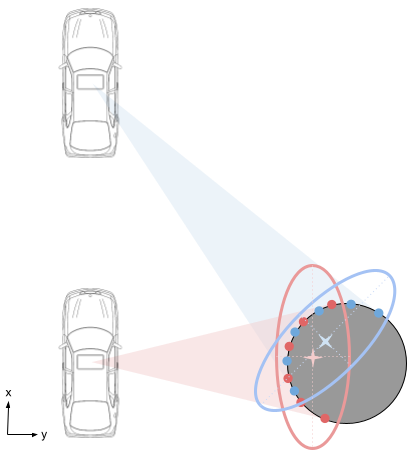

### Assumptions:
Gross rotation and translation have already been estimated by previous scan matching iterations

### Network structure:
Inputs: 
xyz of 25 points randomly sampled from each distribution

Output:
Correction factor translation between the two centers



### Training data generation

(starting with toy example)

1- generate grid of simple shapes in Inventor

2- Rotate randomly, translate randomly and simulate lidar scan of shapes at 2 points in time using MatLab script

3- Sample N points from each object and save to file. Also store information on rotation and translation to seperate file

4- import data here and augment again by duplicating and scaling examples arbitrarily

## TODO

Design network that can guess the direction of ambiguity

Regenerate training data using SLOW MOVEMENT in Ford Dataset

Try again with 100 points per distribution

Scale allowable error threshold between DNN and D2D by radial disatance from origin

Get tf.data() pipeline working


NOTE: py39 env needed with new GPU setup
https://www.tensorflow.org/install/source#gpu


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
# import tensorflow_graphics as tfg
# import tensorflow_graphics.nn.layer.pointnet

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

print(tf.__version__) #requires tensorflow 2.3

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.9.1


Autosaving every 180 seconds


In [2]:
#test pointnet layer...
import tensorflow_graphics as tfg
tfg.nn.layer.pointnet #works in TF2.9 (with CUDNN 8.x)

<module 'tensorflow_graphics.nn.layer.pointnet' from 'C:\\Users\\Derm\\anaconda3\\envs\\py39\\lib\\site-packages\\tensorflow_graphics\\nn\\layer\\pointnet.py'>

In [3]:
#define functions to convert between spherical and cartesian coordinate representations
def c2s(pts):
    """ converts points from cartesian coordinates to spherical coordinates """
    r = tf.sqrt(pts[:,0]**2 + pts[:,1]**2 + pts[:,2]**2)
    phi = tf.math.acos(pts[:,2]/r)
    theta = tf.math.atan2(pts[:,1], pts[:,0])

    out = tf.transpose(tf.Variable([r, theta, phi]))
    return(out)
def s2c(pts):
    """converts spherical -> cartesian"""

    x = pts[:,:,0]*tf.math.sin(pts[:,:,2])*tf.math.cos(pts[:,:,1])
    y = pts[:,:,0]*tf.math.sin(pts[:,:,2])*tf.math.sin(pts[:,:,1]) 
    z = pts[:,:,0]*tf.math.cos(pts[:,:,2])

    out = tf.transpose(tf.Variable([x, y, z]))
    # out = tf.Variable([x, y, z])
    return(out)

In [100]:
# old way - non-reduced dimension solution, only feed DNN each point cloud
# #_________________________________________________________________
# #load individual data numpy files
# # d1_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_scan1.npy")
# # d2_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_scan2.npy")
# # gt_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1_ground_truth.npy")

# # print(np.shape(d1_1))

# # d1_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan1.npy")
# # d2_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan2.npy")
# # gt_2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_ground_truth.npy")

# # d1_3 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_scan1.npy")
# # d2_3 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_scan2.npy")
# # gt_3 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v3_ground_truth.npy")

# d1_4 = np.load("D:/TrainingData/KITTI_scan1_100pts.npy")
# d2_4 = np.load("D:/TrainingData/KITTI_scan2_100pts.npy")
# gt_4 = np.load("D:/TrainingData/KITTI_ground_truth_100pts.npy")

# d1_1 = np.load("D:/TrainingData/Ford_scan1_100pts_large_displacement.npy")
# d2_1 = np.load("D:/TrainingData/Ford_scan2_100pts_large_displacement.npy")
# gt_1 = np.load("D:/TrainingData/Ford_ground_truth_100pts_large_displacement.npy")

# # d1_1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.npy")
# # d2_1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan2_300k_50_samples.npy")
# # gt_1 = np.load("C:/Users/Derm/Desktop/big/pshift/ground_truth_300k_50_samples.npy")
# # gt_1 = gt_1*0.1 #scale to match real-world data (vel-> pos)

# d1 = np.append(d1_1, d1_4, axis = 0)
# d2 = np.append(d2_1, d2_4, axis = 0)
# gt = np.append(gt_1, gt_4, axis = 0)

# # d1 = np.append(d1, d1_3, axis = 0)
# # d2 = np.append(d2, d2_3, axis = 0)
# # gt = np.append(gt, gt_3, axis = 0)

# # d1 = np.append(d1, d1_2, axis = 0)
# # d2 = np.append(d2, d2_2, axis = 0)
# # gt = np.append(gt, gt_2, axis = 0)
# #_________________________________________________________________

#small
# d1 = np.loadtxt("training_data/ICET_Ford_scan1.txt")
# d2 = np.loadtxt("training_data/ICET_Ford_scan2.txt")
# gt = np.loadtxt("training_data/ICET_Ford_ground_truth.txt")

#big
# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan1.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_scan2.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2_ground_truth.npy")
# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/scan2_300k_50_samples.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ground_truth_300k_50_samples.npy")
# gt = gt*0.1 #scale to match real-world data (vel-> pos)

#100 pts per scan
# d1 = np.load("D:/TrainingData/Ford_scan1_100pts.npy")
# d2 = np.load("D:/TrainingData/Ford_scan2_100pts.npy")
# gt = np.load("D:/TrainingData/Ford_ground_truth_100pts.npy")
# d1 = np.load("D:/TrainingData/KITTI_scan1_100pts.npy")
# d2 = np.load("D:/TrainingData/KITTI_scan2_100pts.npy")
# gt = np.load("D:/TrainingData/KITTI_ground_truth_100pts.npy")
# d1 = np.load("D:/TrainingData/Ford_scan1_100pts_large_displacement.npy")
# d2 = np.load("D:/TrainingData/Ford_scan2_100pts_large_displacement.npy")
# gt = np.load("D:/TrainingData/Ford_ground_truth_100pts_large_displacement.npy")
d1 = np.loadtxt("D:/TrainingData/simulated_scan1_100pts.txt")
d2 = np.loadtxt("D:/TrainingData/simulated_scan2_100pts.txt")
gt = np.loadtxt("D:/TrainingData/simulated_ground_truth_100pts.txt")
gt = gt*0.1 #scale to match real-world data (vel-> pos)

#reshape but don't convert to tensor
points_per_sample = 100 #50          #poitns sammpled from each voxel
tsplit = 0.9 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)
print(np.shape(x_train))
# print(np.shape(x_test))

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]


(144000, 200, 3)


In [ ]:
#Testing new network structure informed by voxel boundaries
#   input both point clouds AND VOXEL BOUNDS to DNN
#_________________________________________________________________
# big
d1 = np.load("C:/Users/Derm/Desktop/big/pshift/compact_scan1.npy")
d2 = np.load("C:/Users/Derm/Desktop/big/pshift/compact_scan2.npy")
gt = np.load("C:/Users/Derm/Desktop/big/pshift/compact_ground_truth.npy")
LUT = np.load("C:/Users/Derm/Desktop/big/pshift/LUT.npy")
L = np.load("C:/Users/Derm/Desktop/big/pshift/L.npy")
U = np.load("C:/Users/Derm/Desktop/big/pshift/U.npy")
corn = np.load("C:/Users/Derm/Desktop/big/pshift/corn.npy")

#small
# d1 = np.load('training_data/compact_scan1.npy')
# d2 = np.load('training_data/compact_scan2.npy')
# gt = np.load('training_data/compact_ground_truth.npy')
# LUT = np.load('training_data/LUT.npy') 
# L = np.load('training_data/L.npy')
# U = np.load('training_data/U.npy')
# corn = np.load('training_data/corn.npy')
#_________________________________________________________________

#loop through each element of corn and convert from spherical to cartesian
# print(np.shape(corn))
new_corn = np.transpose(s2c(corn), [1,0,2,])
# print(np.shape(new_corn))

#reshape but don't convert to tensor
points_per_sample = 50          #poitns sammpled from each voxel
tsplit = 0.9 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)

#combine voxel bound to each training example
x_train = np.append(x_train, new_corn[:ntrain], axis = 1)
x_test = np.append(x_test, new_corn[ntrain:], axis = 1)

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]
# y_train = gt[:ntrain][:,:,0] #when using compact data
# y_test = gt[ntrain:][:,:,0]
LUT = tf.convert_to_tensor(LUT)[ntrain:]
U = tf.convert_to_tensor(U)[ntrain:]
L = tf.convert_to_tensor(L)[ntrain:]
corn_train = corn[:ntrain]
corn_test = corn[ntrain:]

print(np.shape(x_train))
# print(np.shape(x_test))

## Rescaling and zero-centing each point cloud

| MAE      | Batch Size     |    Epochs | Train Dataset | Notes | Filename|
| ----------- | ----------- | --------- | --------   | | |
| 0.310  | 4096 |  10   |  Zero centerd on 1, rescaled  | | |
| 0.054   | 256   | 30    | KITTI + Ford large translation | | |
| 0.049   | 256   | 100    | KITTI + Ford large translation | Reduced Network Size | FordNet100 |

In [ ]:
#100 pts per scan
# d1 = np.load("D:/TrainingData/Ford_scan1_100pts.npy")
# d2 = np.load("D:/TrainingData/Ford_scan2_100pts.npy")
# gt = np.load("D:/TrainingData/Ford_ground_truth_100pts.npy")
d1 = np.load("D:/TrainingData/Ford_scan1_100pts_large_displacement.npy")
d2 = np.load("D:/TrainingData/Ford_scan2_100pts_large_displacement.npy")
gt = np.load("D:/TrainingData/Ford_ground_truth_100pts_large_displacement.npy")

#reshape but don't convert to tensor
points_per_sample = 100 #50          #poitns sammpled from each voxel
tsplit = 0.95 #0.95                   #this fraction goes into training

scan1 = np.reshape(d1, [-1, points_per_sample, 3])
scan2 = np.reshape(d2, [-1, points_per_sample, 3])
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())

#center about zero
mu1 = np.mean(scan1, axis = 1)[:, None, :]
scan1 = scan1 - mu1
scan2 = scan2 - mu1

#make unit scale
RMS = np.std(scan1, axis=(1,2))
scan1 = scan1/RMS[:,None,None]

mu2 = np.mean(scan2, axis = 1)[:, None, :]
scan2 = scan2/RMS[:,None,None]
gt = gt/RMS[:,None]

x_train = np.append(scan1[:ntrain], scan2[:ntrain], axis = 1)
x_test = np.append(scan1[ntrain:], scan2[ntrain:], axis = 1)

y_train = gt[:ntrain] #for standard training/ test data
y_test = gt[ntrain:]
# print(np.shape(x_train))

In [148]:
#train network
from network import Net
# from network import TestNet as Net
# from network import FFNet as Net
# from network import PointNet as Net
# from network import Attention as Net

runLen = 300

def scheduler(epoch, learning_rate):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        learning_rate = 0.002
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.001
        return learning_rate
    if epoch >= part2:
        learning_rate = 0.00025
        return learning_rate

model = Net() #comment out to re-train existing network
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.MeanSquaredError()) #was MeanSquaredError()

summary = model.summary()
print(summary)
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
cp = tf.keras.callbacks.ModelCheckpoint("FordNetCP.kmod", monitor = 'val_loss', save_best_only = True) 

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

trace = model.fit(x = x_train, y = y_train, batch_size = 64, epochs=runLen, verbose=1, 
                  validation_split = 0.2, shuffle=True, callbacks = [cp])

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 200, 3)]          0         
                                                                 
 tf.expand_dims_15 (TFOpLamb  (None, 200, 3, 1)        0         
 da)                                                             
                                                                 
 conv2d_60 (Conv2D)          (None, 200, 1, 64)        256       
                                                                 
 batch_normalization_107 (Ba  (None, 200, 1, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_61 (Conv2D)          (None, 200, 1, 64)        4160      
                                                                 
 batch_normalization_108 (Ba  (None, 200, 1, 64)       256

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 20s 11ms/step - loss: 0.3301 - val_loss: 0.1033
Epoch 2/300
1796/1800 [============================>.] - ETA: 0s - loss: 0.1041

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.1041 - val_loss: 0.0978
Epoch 3/300
1798/1800 [============================>.] - ETA: 0s - loss: 0.0858

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0858 - val_loss: 0.0869
Epoch 4/300
1797/1800 [============================>.] - ETA: 0s - loss: 0.0771

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0770 - val_loss: 0.0555
Epoch 5/300
1795/1800 [============================>.] - ETA: 0s - loss: 0.0676

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0675 - val_loss: 0.0275
Epoch 6/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0592 - val_loss: 0.0632
Epoch 7/300
1799/1800 [============================>.] - ETA: 0s - loss: 0.0524

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 20s 11ms/step - loss: 0.0524 - val_loss: 0.0257
Epoch 8/300
1800/1800 [==============================] - 17s 10ms/step - loss: 0.0470 - val_loss: 0.0397
Epoch 9/300
1799/1800 [============================>.] - ETA: 0s - loss: 0.0417

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0417 - val_loss: 0.0163
Epoch 10/300
1795/1800 [============================>.] - ETA: 0s - loss: 0.0386

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0386 - val_loss: 0.0154
Epoch 11/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0350 - val_loss: 0.0154
Epoch 12/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0329 - val_loss: 0.0338
Epoch 13/300
1800/1800 [==============================] - ETA: 0s - loss: 0.0302

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0302 - val_loss: 0.0114
Epoch 14/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0297 - val_loss: 0.0195
Epoch 15/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0285 - val_loss: 0.0190
Epoch 16/300
1800/1800 [==============================] - 17s 10ms/step - loss: 0.0269 - val_loss: 0.0156
Epoch 17/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0266 - val_loss: 0.0118
Epoch 18/300
1800/1800 [==============================] - 17s 10ms/step - loss: 0.0259 - val_loss: 0.0141
Epoch 19/300
1797/1800 [============================>.] - ETA: 0s - loss: 0.0250

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0250 - val_loss: 0.0097
Epoch 20/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0245 - val_loss: 0.0192
Epoch 21/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0235 - val_loss: 0.0160
Epoch 22/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0234 - val_loss: 0.0107
Epoch 23/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0230 - val_loss: 0.0115
Epoch 24/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0221 - val_loss: 0.0108
Epoch 25/300
1799/1800 [============================>.] - ETA: 0s - loss: 0.0219

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0219 - val_loss: 0.0094
Epoch 26/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0221 - val_loss: 0.0163
Epoch 27/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0219 - val_loss: 0.0098
Epoch 28/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0210 - val_loss: 0.0142
Epoch 29/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0214 - val_loss: 0.0171
Epoch 30/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0206 - val_loss: 0.0152
Epoch 31/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0208 - val_loss: 0.0106
Epoch 32/300
1798/1800 [============================>.] - ETA: 0s - loss: 0.0210

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0210 - val_loss: 0.0086
Epoch 33/300
1800/1800 [==============================] - ETA: 0s - loss: 0.0200

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0200 - val_loss: 0.0074
Epoch 34/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0202 - val_loss: 0.0079
Epoch 35/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0201 - val_loss: 0.0103
Epoch 36/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0197 - val_loss: 0.0077
Epoch 37/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0193 - val_loss: 0.0084
Epoch 38/300
1798/1800 [============================>.] - ETA: 0s - loss: 0.0190

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0190 - val_loss: 0.0064
Epoch 39/300
1796/1800 [============================>.] - ETA: 0s - loss: 0.0194

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0194 - val_loss: 0.0063
Epoch 40/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0193 - val_loss: 0.0109
Epoch 41/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0192 - val_loss: 0.0137
Epoch 42/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0194 - val_loss: 0.0090
Epoch 43/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0188 - val_loss: 0.0070
Epoch 44/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0188 - val_loss: 0.0080
Epoch 45/300
1800/1800 [==============================] - ETA: 0s - loss: 0.0185

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 10ms/step - loss: 0.0185 - val_loss: 0.0062
Epoch 46/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0180 - val_loss: 0.0083
Epoch 47/300
1797/1800 [============================>.] - ETA: 0s - loss: 0.0184

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0184 - val_loss: 0.0056
Epoch 48/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0183 - val_loss: 0.0073
Epoch 49/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0181 - val_loss: 0.0069
Epoch 50/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0180 - val_loss: 0.0066
Epoch 51/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0180 - val_loss: 0.0091
Epoch 52/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0180 - val_loss: 0.0062
Epoch 53/300
1797/1800 [============================>.] - ETA: 0s - loss: 0.0176

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 20s 11ms/step - loss: 0.0176 - val_loss: 0.0053
Epoch 54/300
1800/1800 [==============================] - 17s 10ms/step - loss: 0.0175 - val_loss: 0.0069
Epoch 55/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0178 - val_loss: 0.0065
Epoch 56/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0171 - val_loss: 0.0076
Epoch 57/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0177 - val_loss: 0.0071
Epoch 58/300
1800/1800 [==============================] - ETA: 0s - loss: 0.0167

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0167 - val_loss: 0.0050
Epoch 59/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0174 - val_loss: 0.0062
Epoch 60/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0174 - val_loss: 0.0063
Epoch 61/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0170 - val_loss: 0.0066
Epoch 62/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0170 - val_loss: 0.0052
Epoch 63/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0166 - val_loss: 0.0063
Epoch 64/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0166 - val_loss: 0.0075
Epoch 65/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0173 - val_loss: 0.0069
Epoch 66/300
1799/1800 [============================>.] - ETA: 0s - loss: 0.0170

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 10ms/step - loss: 0.0170 - val_loss: 0.0050
Epoch 67/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0166 - val_loss: 0.0064
Epoch 68/300
1797/1800 [============================>.] - ETA: 0s - loss: 0.0164

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0164 - val_loss: 0.0045
Epoch 69/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0165 - val_loss: 0.0053
Epoch 70/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0168 - val_loss: 0.0053
Epoch 71/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0163 - val_loss: 0.0078
Epoch 72/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0164 - val_loss: 0.0058
Epoch 73/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0161 - val_loss: 0.0105
Epoch 74/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0164 - val_loss: 0.0048
Epoch 75/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0160 - val_loss: 0.0054
Epoch 76/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0162 - val_loss: 0.0046
Epoch 77/300
1800/1800 [==============================] - 1

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0160 - val_loss: 0.0045
Epoch 97/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0154 - val_loss: 0.0061
Epoch 98/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0152 - val_loss: 0.0066
Epoch 99/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0160 - val_loss: 0.0048
Epoch 100/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0153 - val_loss: 0.0058
Epoch 101/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0154 - val_loss: 0.0052
Epoch 102/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0152 - val_loss: 0.0066
Epoch 103/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0156 - val_loss: 0.0069
Epoch 104/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0152 - val_loss: 0.0070
Epoch 105/300
1800/1800 [=============================

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0151 - val_loss: 0.0045
Epoch 112/300
1799/1800 [============================>.] - ETA: 0s - loss: 0.0152

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0152 - val_loss: 0.0043
Epoch 113/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0149 - val_loss: 0.0046
Epoch 114/300
1800/1800 [==============================] - 17s 10ms/step - loss: 0.0150 - val_loss: 0.0050
Epoch 115/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0154 - val_loss: 0.0044
Epoch 116/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0150 - val_loss: 0.0050
Epoch 117/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0154 - val_loss: 0.0058
Epoch 118/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0154 - val_loss: 0.0045
Epoch 119/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0150 - val_loss: 0.0048
Epoch 120/300
1800/1800 [==============================] - 17s 10ms/step - loss: 0.0152 - val_loss: 0.0063
Epoch 121/300
1800/1800 [==========================

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0153 - val_loss: 0.0039
Epoch 136/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0148 - val_loss: 0.0048
Epoch 137/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0150 - val_loss: 0.0075
Epoch 138/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0146 - val_loss: 0.0083
Epoch 139/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0150 - val_loss: 0.0091
Epoch 140/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0146 - val_loss: 0.0052
Epoch 141/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0144 - val_loss: 0.0051
Epoch 142/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0145 - val_loss: 0.0119
Epoch 143/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0148 - val_loss: 0.0047
Epoch 144/300
1800/1800 [==========================

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0145 - val_loss: 0.0037
Epoch 149/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0146 - val_loss: 0.0074
Epoch 150/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0145 - val_loss: 0.0072
Epoch 151/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0145 - val_loss: 0.0054
Epoch 152/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0145 - val_loss: 0.0070
Epoch 153/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0142 - val_loss: 0.0058
Epoch 154/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0145 - val_loss: 0.0055
Epoch 155/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0146 - val_loss: 0.0051
Epoch 156/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0141 - val_loss: 0.0048
Epoch 157/300
1800/1800 [==========================

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0146 - val_loss: 0.0036
Epoch 167/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0142 - val_loss: 0.0046
Epoch 168/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0141 - val_loss: 0.0051
Epoch 169/300
1800/1800 [==============================] - 17s 10ms/step - loss: 0.0150 - val_loss: 0.0077
Epoch 170/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0142 - val_loss: 0.0044
Epoch 171/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0144 - val_loss: 0.0045
Epoch 172/300
1798/1800 [============================>.] - ETA: 0s - loss: 0.0145

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0145 - val_loss: 0.0035
Epoch 173/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0142 - val_loss: 0.0077
Epoch 174/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0146 - val_loss: 0.0138
Epoch 175/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0145 - val_loss: 0.0153
Epoch 176/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0143 - val_loss: 0.0071
Epoch 177/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0142 - val_loss: 0.0055
Epoch 178/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0141 - val_loss: 0.0104
Epoch 179/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0144 - val_loss: 0.0084
Epoch 180/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0142 - val_loss: 0.0050
Epoch 181/300
1800/1800 [==========================

1800/1800 [==============================] - 18s 10ms/step - loss: 0.0136 - val_loss: 0.0058
Epoch 249/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0137 - val_loss: 0.0092
Epoch 250/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0140 - val_loss: 0.0144
Epoch 251/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0136 - val_loss: 0.0069
Epoch 252/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0138 - val_loss: 0.0050
Epoch 253/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0141 - val_loss: 0.0075
Epoch 254/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0137 - val_loss: 0.0069
Epoch 255/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0139 - val_loss: 0.0059
Epoch 256/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0144 - val_loss: 0.0054
Epoch 257/300
1800/1800 [==========================

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0131 - val_loss: 0.0035
Epoch 277/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0135 - val_loss: 0.0051
Epoch 278/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0142 - val_loss: 0.0036
Epoch 279/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0136 - val_loss: 0.0045
Epoch 280/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0137 - val_loss: 0.0043
Epoch 281/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0139 - val_loss: 0.0051
Epoch 282/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0141 - val_loss: 0.0047
Epoch 283/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0132 - val_loss: 0.0041
Epoch 284/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0141 - val_loss: 0.0085
Epoch 285/300
1800/1800 [==========================

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 19s 11ms/step - loss: 0.0136 - val_loss: 0.0034
Epoch 290/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0137 - val_loss: 0.0043
Epoch 291/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0142 - val_loss: 0.0064
Epoch 292/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0143 - val_loss: 0.0041
Epoch 293/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0137 - val_loss: 0.0053
Epoch 294/300
1800/1800 [==============================] - 17s 10ms/step - loss: 0.0139 - val_loss: 0.0053
Epoch 295/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0142 - val_loss: 0.0038
Epoch 296/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0138 - val_loss: 0.0046
Epoch 297/300
1796/1800 [============================>.] - ETA: 0s - loss: 0.0138

INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


INFO:tensorflow:Assets written to: FordNetCP.kmod\assets


1800/1800 [==============================] - 20s 11ms/step - loss: 0.0138 - val_loss: 0.0033
Epoch 298/300
1800/1800 [==============================] - 17s 10ms/step - loss: 0.0138 - val_loss: 0.0034
Epoch 299/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0137 - val_loss: 0.0041
Epoch 300/300
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0138 - val_loss: 0.0081


### Top Scores
#### C:/Users/Derm/Desktop/big/pshift/scan1_10k_50_samples.txt 
 no rotation in objects used to train DNN 

-- 0.69 MAE using the CNN kernel hack presented in PCR-Net

-- 0.60 MAE using my strategy

-- 0.36 MAE using simplified PCR-Net

#### C:/Users/Derm/Desktop/big/pshift/scan1_1k_50_samples.txt 

-- 0.56 MAE, bs=32

#### C:/Users/Derm/Desktop/big/pshift/scan1_300k_50_samples.txt 

-- 0.39 MAE, bs = 64, epoch = 99 (saved as <Net.kmod>)

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford.txt

-- 0.047 MAE, bs = 256, epoch = 300

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v2.txt
(100 shifts from 10 frames)

-- 0.030 MAE, bs = 512, epoch = 300

#### C:/Users/Derm/Desktop/big/pshift/ICET_Ford_v1+2.txt
--0.032 MAE, bs = 1024, with cnn, epoch = 100

#### Ford2 + 300k synthetic

-- 0.06 MAE with NET, ?? epoch

-- 0.078 MAE MaxPool1D -> Attention, 30 epoch

### v1+v4
0.04 MAE, bs = 512, w/ 256 Conv and 256 FF, epoch = 30

0.033 MAE, bs = 1024, 64 conv 64 FF, epoch = 100

0.027 MAE, bs = 1024, 64 conv, 64 FF, epoch = 300 [FordNetV3]

### 100pts per scan, single frame displacement
0.1032 MAE, bs = 4096, epoch = 30

0.054 MAE, bs = 1024, epoch = 300


### 100pts per scan, 3 frame displacement

0.09 MAE, bs = 2048, epoch = 30

0.063 MAE, bs = 256, epoch = 30

0.051 MAE, bs = 512, epoch = 300 (FordNET100.kmod)

<IPython.core.display.Javascript object>


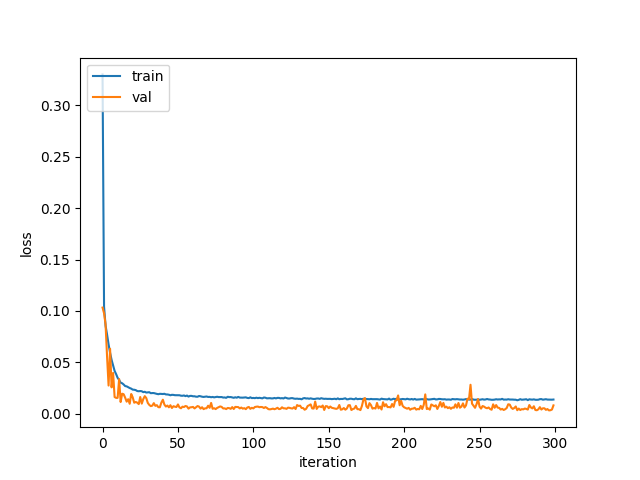

Text(0, 0.5, 'loss')

In [149]:
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('loss')

In [150]:
# estimates = model.predict(x_train[0:100:16])
# print(estimates)
# print(y_train[0:100:16])
estimates = model.predict(x_test[:10]) #* 10
print("estimated translation x y z")
print(estimates)
print("actual translation x y z")
print(y_test[:10])

err = y_test[:10] - estimates
# err = y_train[0:100:16] - estimates

print("\n Error \n",err)

print(tf.math.reduce_mean(tf.math.reduce_sum(err, axis = 1)))




1/1 [==============================] - 0s 82ms/step
estimated translation x y z
[[-0.07626283  0.04553826  0.00191037]
 [-0.85601866  1.1747308  -0.0022834 ]
 [ 0.2982689   0.217469   -0.00617221]
 [ 0.439552   -0.3577514  -0.00448583]
 [-0.76182956 -0.9553071  -0.01094954]
 [-0.6281961   0.18713294 -0.00525113]
 [-0.8114518  -0.15618107  0.00692709]
 [ 0.00874636 -1.583202    0.00805661]
 [ 2.0494785   0.6395744  -0.00128283]
 [-0.6330379   0.5453499  -0.0078602 ]]
actual translation x y z
[[-0.03900862 -0.00252469  0.00983793]
 [-0.92234821  1.20215251  0.0271747 ]
 [ 0.29670045  0.23342946  0.02257404]
 [ 0.41960868 -0.51426704 -0.0208629 ]
 [-0.88891482 -1.02040141 -0.01133299]
 [-0.64669719  0.20112903  0.04037049]
 [-0.79335907 -0.14482276  0.02659841]
 [ 0.03249937 -1.67800926 -0.01326455]
 [ 2.03155115  0.63888087 -0.07322657]
 [-0.77406056  0.50522957  0.03960188]]

 Error 
 [[ 0.03725422 -0.04806295  0.00792756]
 [-0.06632955  0.02742173  0.0294581 ]
 [-0.00156847  0.01596045

In [151]:
%%latex
$$
\begin{aligned}
& \text {Table 1.1. Performance on Normalized Training Data }\\
&\begin{array}{cccc}
\hline \hline \text { } & \text { Mean Absolute Error } & \text { Batch Size } & \text { Epochs } & \text {Notes} \\
\hline 
\text{Scaled and Zeroed} & 0.6297 & 4096 & 10 & \text {asdf } \\
- & - & - & - \\
- & - & - & - \\
\hline
\end{array}
\end{aligned}
$$

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


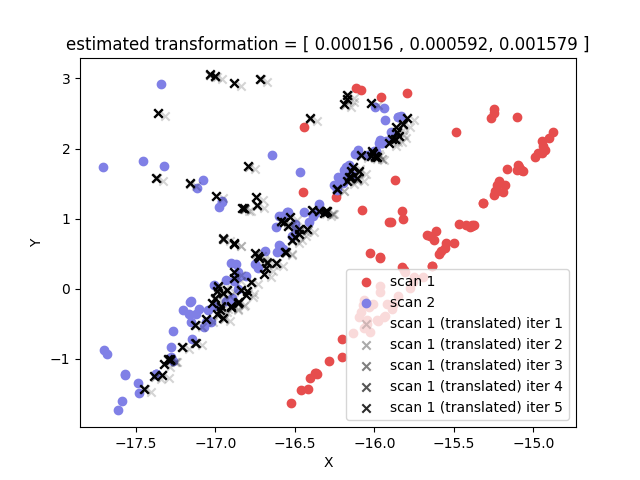

n =  956
1/1 [==============================] - 0s 11ms/step

 correct soln [-0.96539616  0.23715037  0.08292844]

 estiamted soln: [[-0.92049756  0.20029152  0.00511211]]

 error from DNN: [[-0.0448986   0.03685885  0.07781633]]

 error in means [0.06620356 0.2655277  0.09597649]


In [152]:
#visualize results of network on test data
#2d plots (x and y only)
fig1, ax1 = plt.subplots()
n = int(np.floor(1000*np.random.rand()))
# n = 8 #sample number (from x_test)

print("n = ", n)

# print(tf.shape(x_test))
# c1 = np.array([x_test[n,:points_per_sample,0].numpy(), x_test[n,:points_per_sample,1].numpy(), x_test[n,:points_per_sample,2].numpy()])
# c2 = np.array([x_test[n,points_per_sample:,0].numpy(), x_test[n,points_per_sample:,1].numpy(), x_test[n,points_per_sample:,2].numpy()])
c1 = np.array([x_test[n,:points_per_sample,0], x_test[n,:points_per_sample,1], x_test[n,:points_per_sample,2]])
c2 = np.array([x_test[n,points_per_sample:(points_per_sample*2),0], x_test[n,points_per_sample:(points_per_sample*2),1], x_test[n,points_per_sample:(points_per_sample*2),2]])
ax1.scatter(c1[0,:], c1[1,:], color = [0.9, 0.3, 0.3], label = 'scan 1')
ax1.scatter(c2[0,:], c2[1,:], color = [0.5, 0.5, 0.9], label = 'scan 2')


inputs = x_test[n][None,:]
# print(x_test[n, 100:])
runlen = 5
corr_sum = np.zeros([1,3]) #init var to store correction contributions
for i in range(runlen):
    correction = model.predict(inputs)[0] #show what the network thinks
#     correction = correction*0.1
#     correction = y_test[n] #show actual solution
    corr_sum += correction
#     print(correction)
    c1 = np.array([c1[0,:] + correction[0], c1[1,:] + correction[1], c1[2,:] + correction[2]])
    inputs = np.append(c1, c2, axis = 1).T[None,:,:]
#     print(tf.shape(inputs))
#     print(tf.shape(x_test[n,None,100:]))
    inputs = np.append(inputs, x_test[n,None,2*points_per_sample:], axis = 1)
    moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0., 0., 0., (i+1)/(runlen+1)],
                        label = 'scan 1 (translated) iter %i' %(i+1))

# moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0.9, 0.3, 0.3, (i+2)/(runlen+2)],
#                         label = 'scan 1 (translated)')

ax1.set_title("estimated transformation = [ %f , %f, %f ]" %(correction[0], correction[1], correction[2]))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.legend(loc = 'best')

print("\n correct soln", y_test[n])
# print("\n y_test", y_test[n]*0.1)
print("\n estiamted soln:", corr_sum)
print("\n error from DNN:", y_test[n] - corr_sum)
print("\n error in means",  y_test[n] + (np.mean(x_test[n,:points_per_sample], axis = 0) - 
      np.mean(x_test[n,points_per_sample:], axis = 0)))

In [153]:
#use Vedo to plot inital and transformed point clouds in 3D 
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

plt1 = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True)
disp = []

#draw scan1 
# disp.append(Points(x_test[n,:points_per_sample].numpy(), c = 'green', r = 5))
disp.append(Points(x_test[n,:points_per_sample], c = 'green', r = 5))

#draw initial scan2
# disp.append(Points(x_test[n,points_per_sample:].numpy(), c = 'red', r = 5))
disp.append(Points(x_test[n,points_per_sample:points_per_sample*2], c = 'red', r = 5))

#draw transformed scan2
disp.append(Points(c1, c = 'blue', r = 5))

plt1.show(disp, "Network Performance Test")
ViewInteractiveWidget(plt1.window)



ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [ ]:
#save network
# model.save("ffnet10k25.kmod")
# model.save("Net.kmod")
# model.save("PIPEnet10.kmod")
# model.save("KITTInet.kmod")
# model.save("FordNet.kmod")
# model.save("FordNetV3.kmod")
# model.save("FordNetCP.kmod")

#load network
# model = tf.keras.models.load_model("Net.kmod")
# model = tf.keras.models.load_model("FordNet.kmod")
# model = tf.keras.models.load_model("PIPEnet10.kmod")
# model = tf.keras.models.load_model("KITTInet.kmod")
# model = tf.keras.models.load_model("FORDNetV3.kmod")

In [ ]:
#test random shuffle layer to enforce training on unordered data
#GOAL: randomize order of each sample in batch SEPRATELY 
#      (i.e. don't have same order for all elements of batch)

test = tf.constant([[1., 3., 4.], [2., 3., 5.], [6., 6., 6.], [0., 0., 0.]])#[None, :, :]
test = tf.Variable([test, 2*test])
print(test)

test = tf.transpose(test, [1,0,2])
test = tf.random.shuffle(test)
test = tf.transpose(test, [1,0,2])
print(test)

### Top scores:

#### 1k dataset
8.23 MSE with no parallelization (vel = [5, 5, 5])

4.2 MSE (vel = [5, 5, 0.01])

3.9 MSE - 50 sample points from each scan

3.34- maxpool on first/ second half, conv after


#### 10k dataset

2.4 MSE 50 samples

1.05 MSE 25 samples -ffNet10k25.kmod

### KITTI drive 005, 100 frames

0.145 - Permnet

0.0895 -PCRnet

0.0520 KITTInet (5/20)

### KITTI drive 005, 150 frames, 50 sample points
0.759 pipeNET

### Ford Campus Drive 01 (200 frame sample)
0.073 - NET, 200 frames, with ground plane

### KITTI Full 00 400 frames, with ground plane
0.0752 net

### KITTI Full 00 400 frames, no ground plane
0.0756

### KITTI Full 00 4500 frames, with ground plane
0.0736 net


### Notes
From PointNet: Small rotations and gaussian noise can successfully augment models to increase training dataset

Need to figure out a way to achieve permutation invariance
Try transformer network i.e. "Attention is all you need"
https://ai.googleblog.com/2021/11/permutation-invariant-neural-networks.html

Can potentially use reflectance as 4th dimension(?)

### Find average error in mean point locations when ground truth solution is applied
Test for indexing when geterating training data using Ford dataset - this error should be minimal when we are correctly indexing gt

In [ ]:
d1 = np.loadtxt('training_data/ICET_Ford_scan1.txt') #available in repo
d2 = np.loadtxt('training_data/ICET_Ford_scan2.txt')
truth = np.loadtxt('training_data/ICET_Ford_ground_truth.txt')

points_per_sample = 50 #25 #50  #num pts per scan - defined in MatLab script
s1 = tf.reshape(tf.convert_to_tensor(d1), [-1, points_per_sample, 3])
s2 = tf.reshape(tf.convert_to_tensor(d2), [-1, points_per_sample, 3])
truth = tf.convert_to_tensor(truth)

In [ ]:
print(tf.shape(s1))
mu1 = tf.math.reduce_mean(s1, axis = 1)
mu2 = tf.math.reduce_mean(s2, axis = 1)
# print("\n mu1", mu1)
# print("\n mu2", mu2)
centers_error = mu1 - mu2 + truth 
# print("\n centers_error", centers_error)

#get mean absolute centers error across all voxels
# mace = tf.math.reduce_mean(abs(centers_error), axis = 0) #absolute error
mace = tf.math.reduce_mean(centers_error, axis = 0)
print("\n mace", mace)